📊 Actual date range in data: 2024-11-03 to 2025-06-09
📈 Number of days with sentiment data: 203


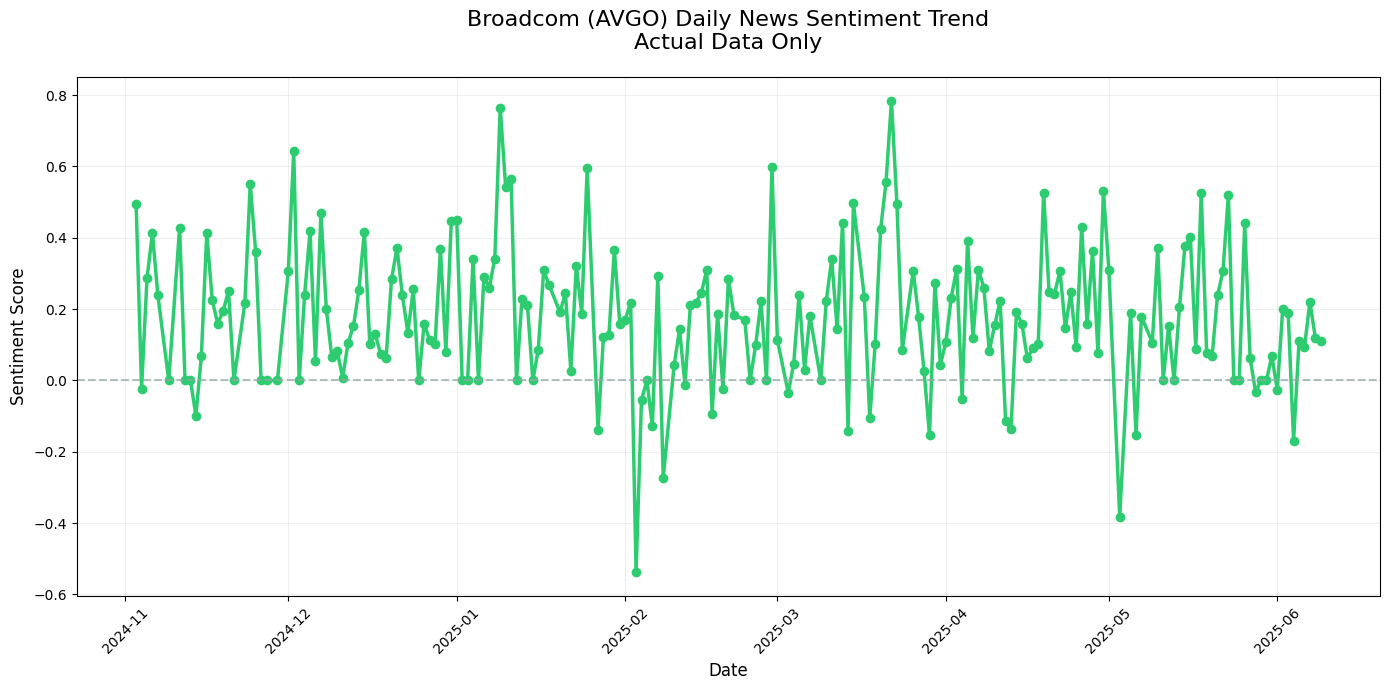


📋 Sample of daily sentiment data:
2024-11-03: 0.494
2024-11-04: -0.023
2024-11-05: 0.287
2024-11-06: 0.412
2024-11-07: 0.238
2024-11-09: 0.000
2024-11-11: 0.428
2024-11-12: 0.000
2024-11-13: 0.000
2024-11-14: -0.099

📊 Final Sentiment Summary:
Date Range: 2024-11-03 to 2025-06-09
Average Sentiment: 0.177
Most Positive Day: 2025-03-22 (0.784)
Most Negative Day: 2025-02-03 (-0.538)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_daily_sentiment(csv_path):
    # Initialize sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    try:
        # Load data
        df = pd.read_csv(csv_path)
        
        # Check required columns
        if 'title' not in df.columns or 'publishedDate' not in df.columns:
            print("❌ CSV missing required 'title' or 'publishedDate' columns")
            return None

        # Calculate sentiment scores
        df['score'] = df['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
        
        # Clean and parse dates - ONLY keep valid dates
        df['date'] = pd.to_datetime(df['publishedDate'], errors='coerce')
        df = df.dropna(subset=['date'])
        
        if df.empty:
            print("❌ No valid dates found after cleaning")
            return None

        # Extract just the date part (no time)
        df['date'] = df['date'].dt.date
        
        # Aggregate by date
        daily_sentiment = df.groupby('date')['score'].mean().reset_index()
        
        print(f"📊 Actual date range in data: {daily_sentiment['date'].min()} to {daily_sentiment['date'].max()}")
        print(f"📈 Number of days with sentiment data: {len(daily_sentiment)}")
        
        # Create plot with ACTUAL data only
        plt.figure(figsize=(14, 7))
        plt.plot(daily_sentiment['date'], daily_sentiment['score'], 
                 color='#2ecc71', linewidth=2.5, marker='o', markersize=6)
        
        # Add reference lines
        plt.axhline(y=0, color='#95a5a6', linestyle='--', alpha=0.7)
        
        # Formatting
        plt.title('Broadcom (AVGO) Daily News Sentiment Trend\nActual Data Only', 
                 fontsize=16, pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Sentiment Score', fontsize=12)
        plt.grid(alpha=0.2)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Show plot
        plt.show()
        
        # Print sample data
        print(f"\n📋 Sample of daily sentiment data:")
        for _, row in daily_sentiment.head(10).iterrows():
            print(f"{row['date']}: {row['score']:.3f}")
        
        return daily_sentiment
    
    except FileNotFoundError:
        print(f"❌ File not found: {csv_path}")
    except Exception as e:
        print(f"❌ Error processing file: {str(e)}")

# Example usage
result = analyze_daily_sentiment("AVGO_news.csv")

if result is not None:
    print(f"\n📊 Final Sentiment Summary:")
    print(f"Date Range: {result['date'].min()} to {result['date'].max()}")
    print(f"Average Sentiment: {result['score'].mean():.3f}")
    print(f"Most Positive Day: {result.loc[result['score'].idxmax(), 'date']} ({result['score'].max():.3f})")
    print(f"Most Negative Day: {result.loc[result['score'].idxmin(), 'date']} ({result['score'].min():.3f})")


In [7]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def analyze_price_sentiment(sentiment_df, ticker='AVGO'):
    """Analyze correlation between stock price and news sentiment"""
    try:
        # Get date range from sentiment data
        start_date = sentiment_df['date'].min().strftime('%Y-%m-%d')
        end_date = sentiment_df['date'].max().strftime('%Y-%m-%d')

        # Fetch stock price data
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_prices = stock_data['Close'].reset_index()
        stock_prices['date'] = pd.to_datetime(stock_prices['Date']).dt.date

        # Merge data on date
        merged_df = sentiment_df.merge(stock_prices, on='date', how='inner')
        
        if merged_df.empty:
            print("❌ No overlapping dates between sentiment and price data")
            return None

        # Calculate correlation
        correlation = merged_df['score'].corr(merged_df['Close'])
        print(f"\n📈 Pearson Correlation Coefficient: {correlation:.3f}")

        # Create figure and axis
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Plot stock price
        ax1.plot(merged_df['date'], merged_df['Close'], 
                color='#1f77b4', linewidth=2, label='Stock Price')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Stock Price ($)', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        
        # Create twin axis for sentiment
        ax2 = ax1.twinx()
        ax2.plot(merged_df['date'], merged_df['score'], 
                color='#ff7f0e', linewidth=2, linestyle='--', 
                label='Sentiment Score')
        ax2.set_ylabel('Sentiment Score', color='#ff7f0e', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#ff7f0e')
        
        # Add title and grid
        plt.title(f'{ticker} Stock Price vs. Sentiment Correlation: {correlation:.3f}', 
                fontsize=16, pad=20)
        plt.grid(alpha=0.3)
        
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.tight_layout()
        plt.show()

        return correlation

    except Exception as e:
        print(f"❌ Error in analysis: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    # First get sentiment data (replace with your actual sentiment analysis call)
    sentiment_data = pd.DataFrame({
        'date': pd.date_range('2024-01-01', '2024-01-10'),
        'score': np.random.uniform(-1, 1, 10)
    })
    sentiment_data['date'] = sentiment_data['date'].dt.date
    
    # Run correlation analysis
    corr_result = analyze_price_sentiment(sentiment_data)
    
    # Print interpretation
    if corr_result is not None:
        print("\n🔍 Interpretation Guide:")
        print("+1.0: Perfect positive correlation")
        print("+0.5 to +1.0: Strong positive correlation")
        print("+0.3 to +0.5: Moderate positive correlation")
        print("-0.3 to +0.3: Weak or no correlation")
        print("-0.5 to -0.3: Moderate negative correlation")
        print("-1.0 to -0.5: Strong negative correlation")


[*********************100%***********************]  1 of 1 completed

❌ Error in analysis: 'Close'
